# Homework 7: Outlier Analysis

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
# Define folder paths relative to this notebook
raw_dir = Path.cwd().parent / "data" / "raw"
processed_dir = Path.cwd().parent / "data" / "processed"

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01, size=len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at /Users/svolety/Desktop/bootcamp IV/bootcamp/homework/homework7/data/raw/outliers_homework.csv. Skipping CSV creation to avoid overwrite.


In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
np.random.seed(17)

In [4]:
data_path = raw_dir / "outliers_homework.csv"
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


In [5]:
src_path = Path.cwd().parent / "src"
import sys
sys.path.append(str(src_path))

from outlier_analysis import *

In [6]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr_k_1.5'] = detect_outliers_iqr(df[target_col],1.5)
df['outlier_iqr_k_3'] = detect_outliers_iqr(df[target_col],3.0)
df['outlier_z_2.5'] = detect_outliers_zscore(df[target_col], threshold=2.5)
df['outlier_z_3'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df['outlier_z_3.5'] = detect_outliers_zscore(df[target_col], threshold=3.5)
df[['outlier_iqr_k_1.5', 'outlier_iqr_k_3','outlier_z_2.5','outlier_z_3','outlier_z_3.5']].mean()  # fraction flagged

outlier_iqr_k_1.5    0.078261
outlier_iqr_k_3      0.043478
outlier_z_2.5        0.043478
outlier_z_3          0.043478
outlier_z_3.5        0.043478
dtype: float64

In [7]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline;margin-right:20px"'), raw=True)

In [8]:
display_side_by_side(df[df['outlier_iqr_k_1.5']==True][['date','daily_return','outlier_iqr_k_1.5']],df[df['outlier_iqr_k_3']==True][['date','daily_return','outlier_iqr_k_3']])

,date,daily_return,outlier_iqr_k_1.5
41,2022-03-01,0.031952,True
63,2022-03-31,-0.031101,True
85,2022-05-02,0.174843,True
86,2022-05-03,-0.168258,True
87,2022-05-04,-0.033999,True
89,2022-05-06,-0.196672,True
90,2022-05-09,0.212402,True
92,2022-05-11,0.028711,True
93,2022-05-12,-0.178729,True
,date,daily_return,outlier_iqr_k_3


In [9]:
display_side_by_side(df[df['outlier_z_2.5']==True][['date','daily_return','outlier_z_2.5']],df[df['outlier_z_3']==True][['date','daily_return','outlier_z_3']],df[df['outlier_z_3.5']==True][['date','daily_return','outlier_z_3.5']])

,date,daily_return,outlier_z_2.5
85,2022-05-02,0.174843,True
86,2022-05-03,-0.168258,True
89,2022-05-06,-0.196672,True
90,2022-05-09,0.212402,True
93,2022-05-12,-0.178729,True
,date,daily_return,outlier_z_3
85,2022-05-02,0.174843,True
86,2022-05-03,-0.168258,True
89,2022-05-06,-0.196672,True
90,2022-05-09,0.212402,True


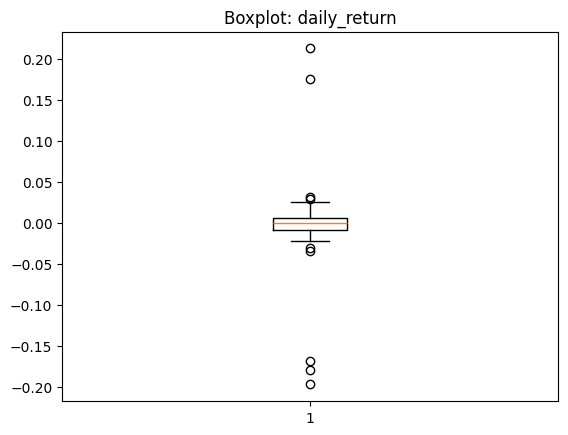

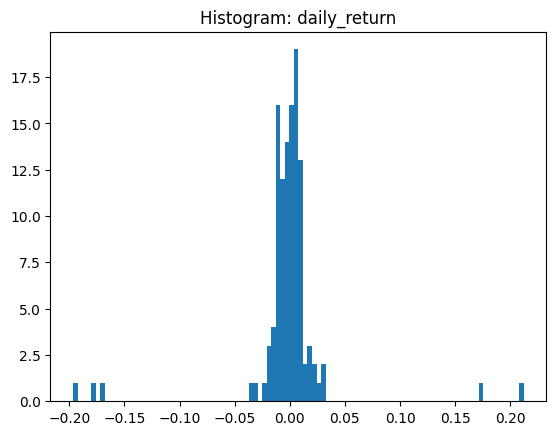

In [10]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=100)
plt.title(f'Histogram: {target_col}')
plt.show()


In [16]:
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr_k_1.5'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col],lower=0.05,upper=0.95)
    w1 = winsorize_series(df[target_col],lower=0.01,upper=0.99)
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001434,-0.000039,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.009443,0.010623


In [17]:
df['winsorized_10%'] = w
df['winsorized_2%'] = w1

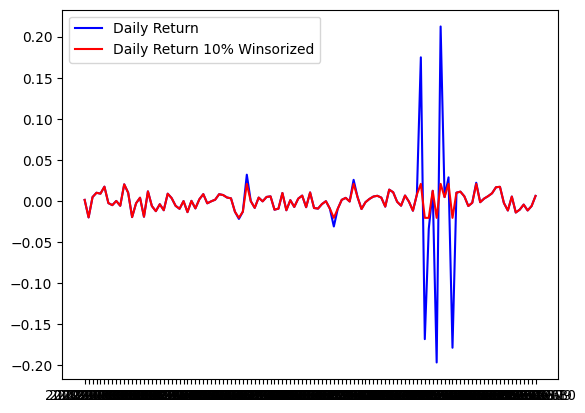

In [20]:
plt.plot(df['date'], df['daily_return'], label="Daily Return", color = "blue")
plt.plot(df['date'], df['winsorized_10%'], label="Daily Return 10% Winsorized", color = "red")
plt.legend()
plt.show()

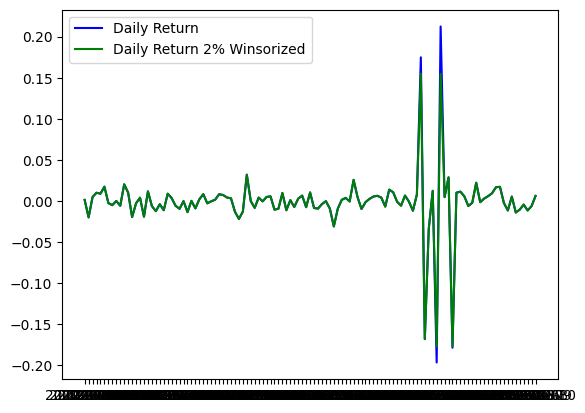

In [19]:
plt.plot(df['date'], df['daily_return'], label="Daily Return", color = "blue")
plt.plot(df['date'], df['winsorized_2%'], label="Daily Return 2% Winsorized", color = "green")
plt.legend()
plt.show()

In [15]:
summ_filtered = df.loc[~df['outlier_iqr_k_3'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})

comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

,all,filtered_iqr,winsorized
mean,-0.001434,-0.000078,-0.000251
median,-0.000187,-0.000100,-0.000187
std,0.040579,0.011059,0.010623


## Reflections on Outlier Detection

**IQR**

- IQR assumes the threshold for outliers is +- 1.5 SDs, because it does not assume normality of data - but this flags valid observations as "outliers" - we know this because we know the "injected" shock values.

**Z-score**

- The Z-score method uses +- 3 SDs because this should encompass 99.7% of data, and picks up on all injected shocks. Changing the threshold to +- 2.5, +- 3.5 does not necessarily shift any outliers being picked up.

**Winsorization**

- Picks up extremes and clips - here I've chosen a 10% winsorization threshold (-5%, +5%). Using a standard 2% winsorization, did not minimize the scale of outliers by very much (see plots above, 10% winsorization results in a more "smooth" time series). But the 10% winsorization gets rid of the shocks almost entirely - and we might not want to lose valid time signal data.

Ideally, the Z-score method is most ideal when data is assumed to be normal (which for daily price returns it is) and IQR might be better if we assume the data to be skewed (or fatter tails). Winsorization "smooths" away the shocks, so it might be most sensitive to threshold choices and these need to be calibrated carefully.

For daily returns data, it might be best to use a z-score method of identifying outliers (as opposed to IQR calculations) or use a 5% winsorization to smooth shock impact (I examine 10% and 2%).
